In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import math
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
###set file for imports
t='_tsubsonly'

In [5]:
##### import GAMS results
#########ra characteristics

hhtrn0_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/hhtrn0_d_rpt.csv'%t)
del hhtrn0_d_rpt['file']
hhtrn0_d_rpt=hhtrn0_d_rpt.groupby(['r','h','sk'],as_index=False).sum()

#savings
sav0_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/sav0_d_rpt.csv'%t)
del sav0_d_rpt['file']

#labor tax rate
tl0_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/tl0_d_rpt.csv'%t)
del tl0_d_rpt['file']

#updated capital endowment
ke0_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/ke0_d_rpt.csv'%t)
del ke0_d_rpt['file']

#initial labor endowment
le0_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/le0_d_rpt.csv'%t)
del le0_d_rpt['file']

#new labor endowment
le0_d_rpt0=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/le0_d_rpt0.csv'%t)
del le0_d_rpt0['file']

#cons0_rpt(r,h,sk)=c0_h_d(r,h,sk);
cons0_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/cons0_rpt.csv'%t)
del cons0_rpt['file']

####cons demand benchmark
cd0_h_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/cd0_h_d_rpt.csv'%t)
del cd0_h_d_rpt['file']

####sector labor demand by skill
ld0_d_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/ld0_d_rpt.csv'%t)
# del ld0_d_rpt['file']

ys0_rpt=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/ys0_rpt.csv'%t)
del ys0_rpt['file']

kd0_rpt= pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/kd0_rpt.csv'%t)
del kd0_rpt['file']

###intermediate goods demand


id0_rpt= pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/id0_rpt.csv'%t)
del id0_rpt['file']

###INITIAL LABOR SUPPLY
labor_b=pd.read_csv('/Users/hannahkamen/Downloads/clim/csv%s/le0_d_rpt00.csv'%t)
labor_b=labor_b[['file','region','household','benchmark_le0','skill']].reset_index()
labor_b=labor_b.rename(columns={'file':'r','region':'q','skill':'sk','household':'h'})
del labor_b['index']
shares=pd.read_csv('/Users/hannahkamen/Downloads/le0_shr2.csv')

shares_u=shares.drop_duplicates(subset=['q','h','sk']).pivot(index=['q','h'],columns='sk',values='skill_shr').reset_index()
shares_u['diff']=shares_u['skl']-shares_u['unskl']

shocks=pd.read_csv('/Users/hannahkamen/Downloads/le0_shock0_v2_test2_adj.csv')
shocks=shocks.rename(columns={'skill_shr':'pct_shock'})
shocks_lm=shocks[(shocks['r']==shocks['q'])]



#### Plot Counterfactuals

Text(0, 0.5, 'Benchmark Capital Endowment')

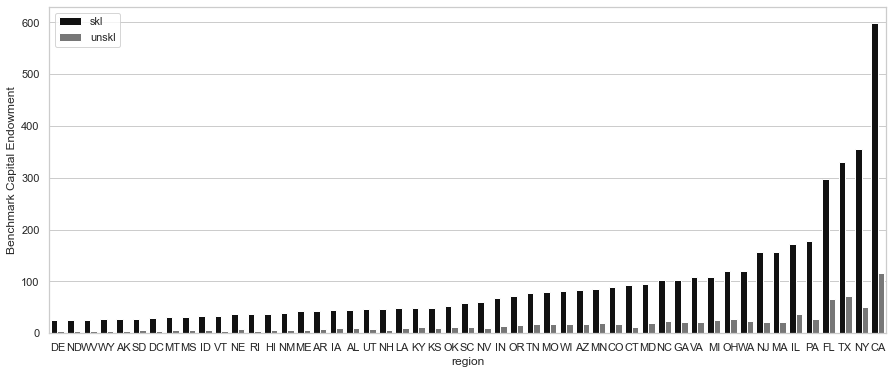

In [26]:
capital_gr=ke0_d_rpt.groupby(['region','skill'],as_index=False).agg({'benchmark_k':sum})

fig, ax = plt.subplots(1, 1,figsize=(15,6))
capital_gr=capital_gr.sort_values(by=['skill','benchmark_k'],ascending=True).reset_index()

sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=capital_gr,
    x="region", y='benchmark_k',hue='skill',
   palette=['#111111','#777777']
)
plt.legend(loc='upper left')
plt.ylabel("Benchmark Capital Endowment")

Text(0, 0.5, 'Pct Change')

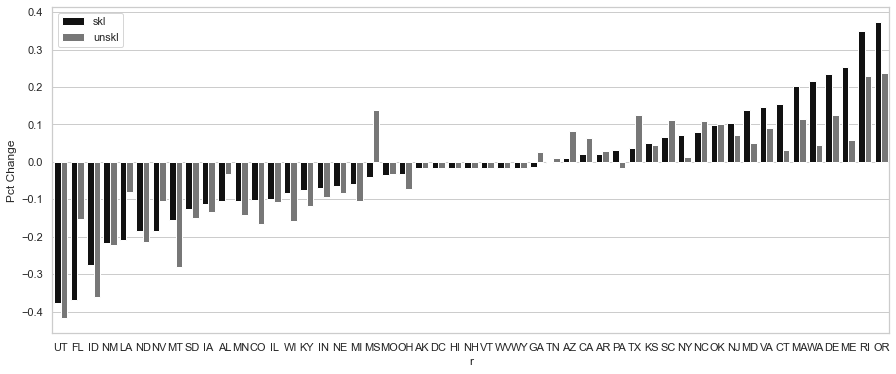

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(15,6))
shocks_lm=shocks_lm.sort_values(by=['sk','pct_shock'],ascending=True).reset_index()

sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=shocks_lm,
    x="r", y='pct_shock',hue='sk',
   palette=['#111111','#777777']
)
plt.legend(loc='upper left')
plt.ylabel("Pct Change")
#g.legend.set_title("")

#### Skill Intensity of demand by state

In [6]:
shocks_lm=shocks_lm.sort_values(by=['sk','pct_shock'],ascending=True).drop_duplicates(subset=['r','sk'])
shocks_lm_pvt=shocks_lm.pivot_table(index='r',columns='sk',values='pct_shock').reset_index()

ld0_d_rpt=ld0_d_rpt.rename(columns={'file':'region'})
ld0_d_rpt_pvt=ld0_d_rpt.pivot_table(index=['region','sector'],columns='skill',values='benchmark_ld0').reset_index()
###group intermediate inputs
id0_rpt_gr=id0_rpt.groupby(by=['region','sector'],as_index=False).sum()

####merge with capital
int_goods=ld0_d_rpt_pvt.merge(kd0_rpt,on=['region','sector'],how='inner').merge(id0_rpt_gr,on=['region','sector'],how='inner')

#####get percent makeup of inputs
int_goods['total_value']=int_goods['skl']+int_goods['unskl']+int_goods['benchmark_capital_demand']+int_goods['benchmark_int_dmd']
int_goods['pct_skl']=int_goods['skl']/int_goods['total_value']
int_goods['pct_unskl']=int_goods['unskl']/int_goods['total_value']
int_goods['pct_capital']=int_goods['benchmark_capital_demand']/int_goods['total_value']


In [7]:
int_dmd_brkdown=id0_rpt.merge(int_goods,left_on=['region','good'], right_on=['region','sector'])

#get labor and capital inputs of intermediate good that sector is demanding
int_dmd_brkdown['skl_int_good']=int_dmd_brkdown['pct_skl']*int_dmd_brkdown['benchmark_int_dmd_x']
int_dmd_brkdown['unskl_int_good']=int_dmd_brkdown['pct_unskl']*int_dmd_brkdown['benchmark_int_dmd_x']
int_dmd_brkdown['capital_int_good']=int_dmd_brkdown['pct_capital']*int_dmd_brkdown['benchmark_int_dmd_x']

####group and sum int inputs over the demanding sector
int_dmd_brkdown_gr=int_dmd_brkdown.groupby(['region','sector_x'],as_index=False).sum()
int_dmd_brkdown_gr=int_dmd_brkdown_gr[['region','sector_x','skl_int_good','unskl_int_good','capital_int_good']]
int_dmd_brkdown_gr=int_dmd_brkdown_gr.rename(columns={'sector_x':'sector'})
####merge intermediate good breakdown with original breakdown and add in intensities of int goods
int_goods_all=int_goods.merge(int_dmd_brkdown_gr,on=['region','sector'])

int_goods_all['skl']=int_goods_all['skl']+int_goods_all['skl_int_good']
int_goods_all['unskl']=int_goods_all['unskl']+int_goods_all['unskl_int_good']
int_goods_all['benchmark_capital_demand']=int_goods_all['benchmark_capital_demand']+int_goods_all['capital_int_good']
int_goods_all=int_goods_all[['region','sector','skl','unskl','benchmark_capital_demand']]
int_goods_all=int_goods_all.rename(columns={'skl':'skl_input','unskl':'unskl_input'})
#recalculate percentages
int_goods_all['total']=int_goods_all['skl_input']+int_goods_all['unskl_input']+int_goods_all['benchmark_capital_demand']

int_goods_all['pct_skl_input']=int_goods_all['skl_input']/int_goods_all['total']
int_goods_all['pct_unskl_input']=int_goods_all['unskl_input']/int_goods_all['total']
int_goods_all['pct_capital_input']=int_goods_all['benchmark_capital_demand']/int_goods_all['total']

####get level consumer demand for goods by skill type
cd0_gr=cd0_h_d_rpt.groupby(['region','good','skill'],as_index=False).sum()
cd0_gr_pvt=cd0_gr.pivot_table(index=['region','good'],columns='skill',values='benchmark_disagg_cons').reset_index()
cd0_gr_pvt=cd0_gr_pvt.rename(columns={'skl':'skl_dmd','unskl':'unskl_dmd'})

cons_dmd_intensity=cd0_gr_pvt.merge(int_goods_all,left_on=['region','good'],right_on=['region','sector'])

###calculate demand intensity
cons_dmd_intensity['skl_skl_dmd']=cons_dmd_intensity['skl_dmd']*cons_dmd_intensity['pct_skl_input']
cons_dmd_intensity['skl_unskl_dmd']=cons_dmd_intensity['skl_dmd']*cons_dmd_intensity['pct_unskl_input']
cons_dmd_intensity['skl_cap_dmd']=cons_dmd_intensity['skl_dmd']*cons_dmd_intensity['pct_capital_input']

cons_dmd_intensity['unskl_skl_dmd']=cons_dmd_intensity['unskl_dmd']*cons_dmd_intensity['pct_skl_input']
cons_dmd_intensity['unskl_unskl_dmd']=cons_dmd_intensity['unskl_dmd']*cons_dmd_intensity['pct_unskl_input']
cons_dmd_intensity['unskl_cap_dmd']=cons_dmd_intensity['unskl_dmd']*cons_dmd_intensity['pct_capital_input']

###limit columns

cons_dmd_intensity=cons_dmd_intensity[['region','good','skl_skl_dmd','skl_unskl_dmd','skl_cap_dmd','unskl_skl_dmd','unskl_unskl_dmd','unskl_cap_dmd']]

###and sum across industries!
cons_dmd_intensity_gr=cons_dmd_intensity.groupby(['region'],as_index=False).sum()


<AxesSubplot:xlabel='region'>

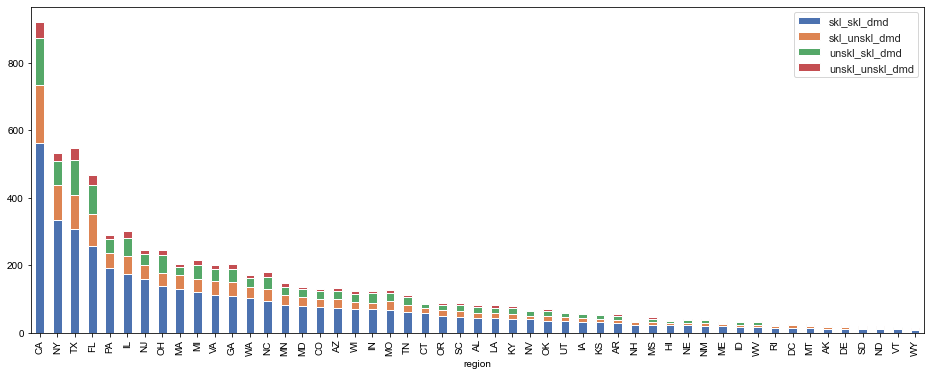

In [8]:
####create stacked bar

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1,figsize=(16,6))
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart

cons_dmd_intensity_gr_lm=cons_dmd_intensity_gr[['region','skl_skl_dmd','skl_unskl_dmd','unskl_skl_dmd','unskl_unskl_dmd']]
cons_dmd_intensity_gr_lm=cons_dmd_intensity_gr_lm.sort_values(by='skl_skl_dmd',ascending=False)
cons_dmd_intensity_gr_lm.set_index('region').plot(kind='bar', stacked=True,ax=ax)


skille

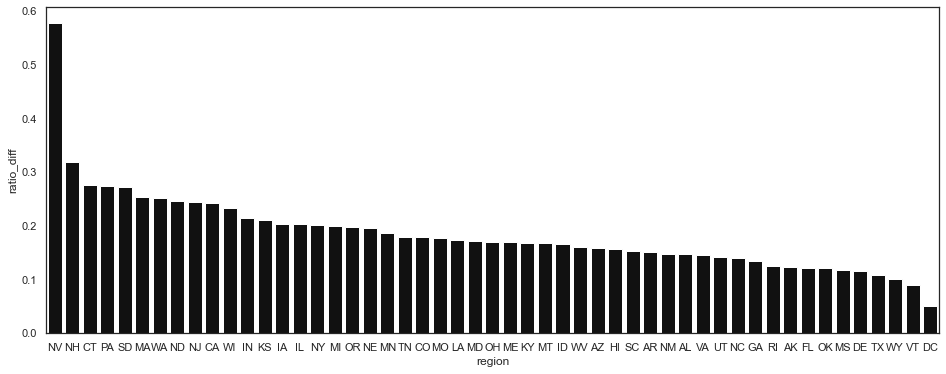

In [9]:
#caculate ratios and plot
cons_dmd_intensity_gr_lm['skl_su_ratio']=cons_dmd_intensity_gr_lm['skl_skl_dmd']/cons_dmd_intensity_gr_lm['skl_unskl_dmd']
cons_dmd_intensity_gr_lm['unskl_su_ratio']=cons_dmd_intensity_gr_lm['unskl_skl_dmd']/cons_dmd_intensity_gr_lm['unskl_unskl_dmd']

cons_dmd_intensity_gr_lm['ratio_diff']=cons_dmd_intensity_gr_lm['skl_su_ratio']-cons_dmd_intensity_gr_lm['unskl_su_ratio']
# cons_ratio_melt=cons_dmd_intensity_gr_lm.melt(id_vars='region',value_vars=['skl_su_ratio','unskl_su_ratio'])

cons_dmd_intensity_gr_lm=cons_dmd_intensity_gr_lm.sort_values(by='ratio_diff',ascending=False)

###plot
fig, ax = plt.subplots(1, 1,figsize=(16,6))


sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=cons_dmd_intensity_gr_lm,
    x="region", y='ratio_diff',
   palette=['#111111']
)



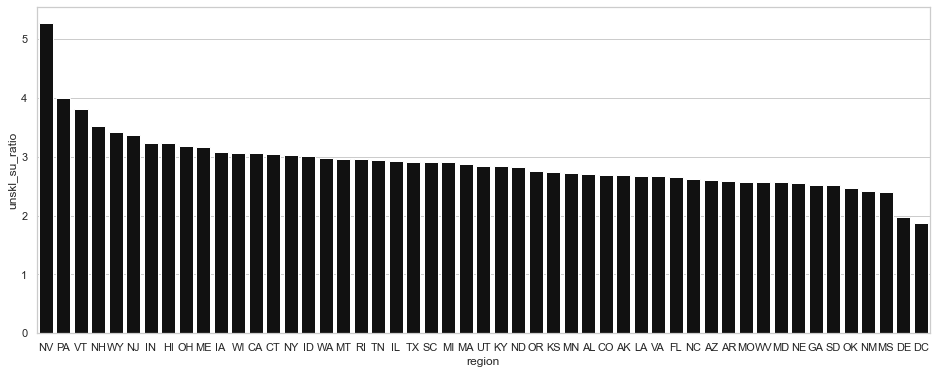

In [10]:
#caculate ratios and plot
cons_dmd_intensity_gr_lm['skl_su_ratio']=cons_dmd_intensity_gr_lm['skl_skl_dmd']/cons_dmd_intensity_gr_lm['skl_unskl_dmd']
cons_dmd_intensity_gr_lm['unskl_su_ratio']=cons_dmd_intensity_gr_lm['unskl_skl_dmd']/cons_dmd_intensity_gr_lm['unskl_unskl_dmd']

cons_dmd_intensity_gr_lm['ratio_diff']=cons_dmd_intensity_gr_lm['skl_su_ratio']-cons_dmd_intensity_gr_lm['unskl_su_ratio']
# cons_ratio_melt=cons_dmd_intensity_gr_lm.melt(id_vars='region',value_vars=['skl_su_ratio','unskl_su_ratio'])

cons_dmd_intensity_gr_lm=cons_dmd_intensity_gr_lm.sort_values(by='unskl_su_ratio',ascending=False)

###plot
fig, ax = plt.subplots(1, 1,figsize=(16,6))


sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=cons_dmd_intensity_gr_lm,
    x="region", y='unskl_su_ratio',
   palette=['#111111']
)


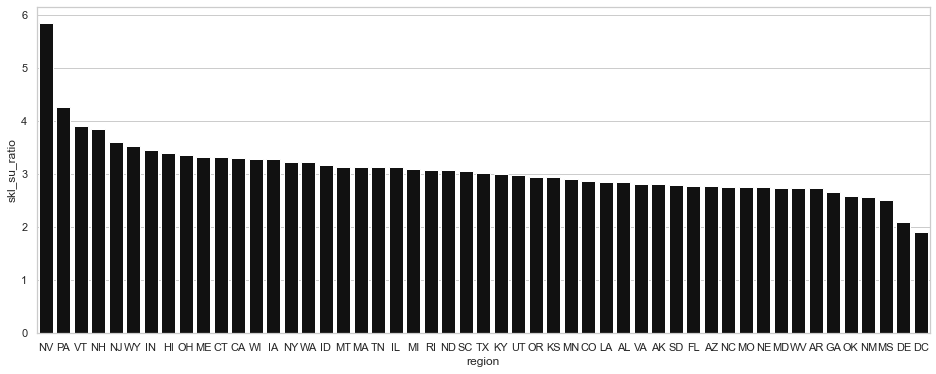

In [11]:
#caculate ratios and plot
cons_dmd_intensity_gr_lm['skl_su_ratio']=cons_dmd_intensity_gr_lm['skl_skl_dmd']/cons_dmd_intensity_gr_lm['skl_unskl_dmd']
cons_dmd_intensity_gr_lm['unskl_su_ratio']=cons_dmd_intensity_gr_lm['unskl_skl_dmd']/cons_dmd_intensity_gr_lm['unskl_unskl_dmd']

cons_dmd_intensity_gr_lm['ratio_diff']=cons_dmd_intensity_gr_lm['skl_su_ratio']-cons_dmd_intensity_gr_lm['unskl_su_ratio']
# cons_ratio_melt=cons_dmd_intensity_gr_lm.melt(id_vars='region',value_vars=['skl_su_ratio','unskl_su_ratio'])

cons_dmd_intensity_gr_lm=cons_dmd_intensity_gr_lm.sort_values(by='skl_su_ratio',ascending=False)

###plot
fig, ax = plt.subplots(1, 1,figsize=(16,6))


sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=cons_dmd_intensity_gr_lm,
    x="region", y='skl_su_ratio',
   palette=['#111111']
)

In [38]:
benchmark_exports.to_excel('/Users/hannahkamen/Downloads/benchmark_exports.xlsx')

#### Percent local exports by industry

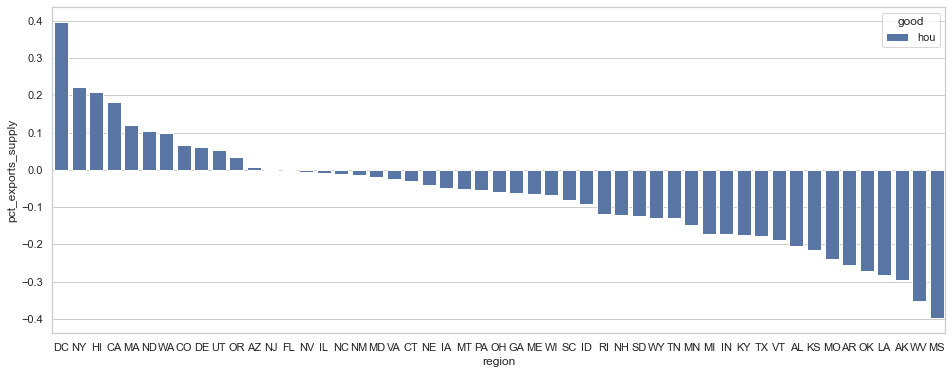

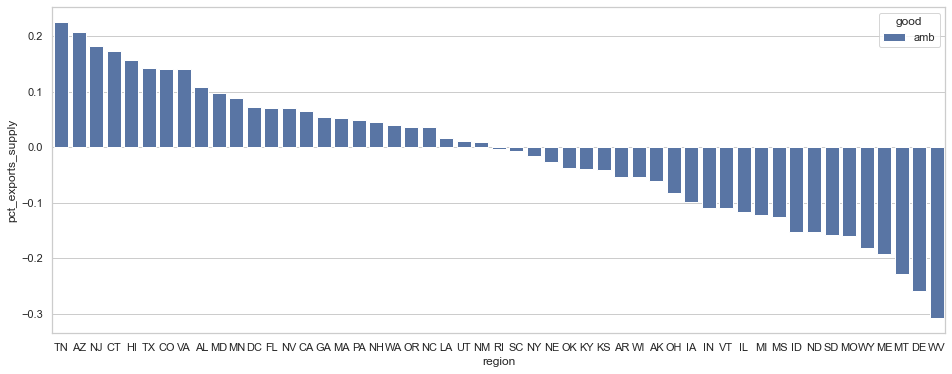

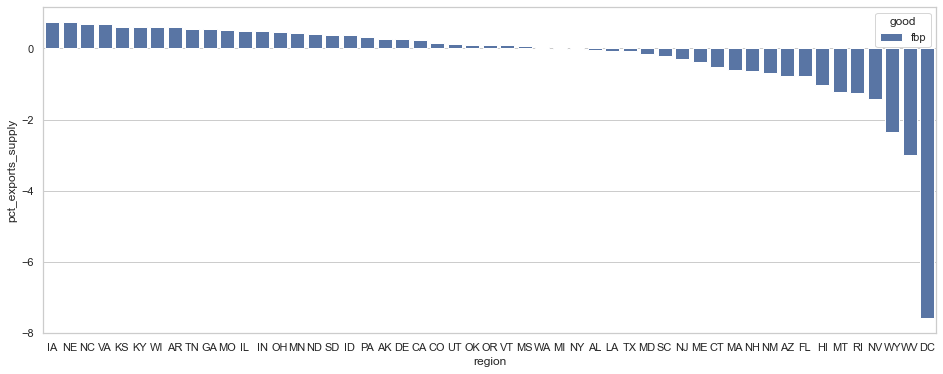

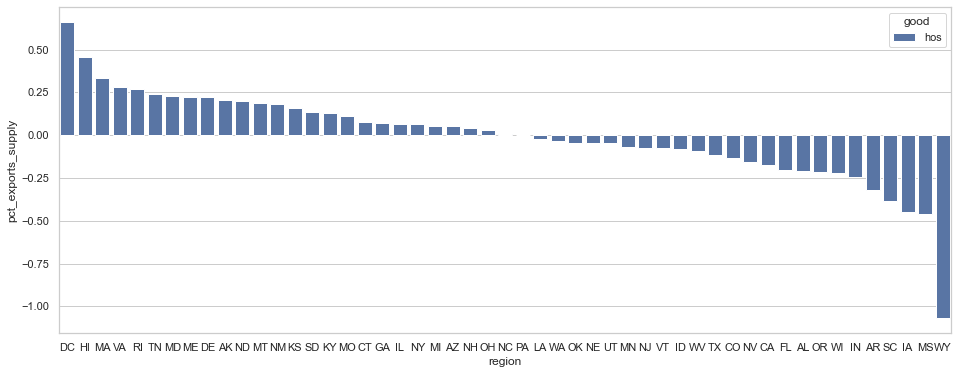

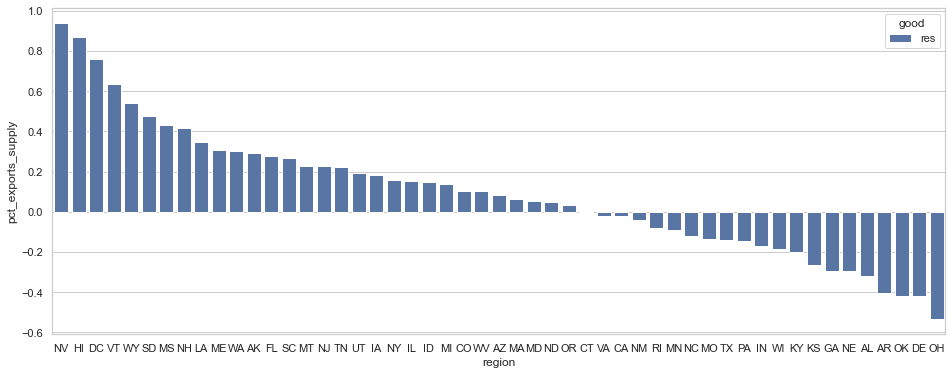

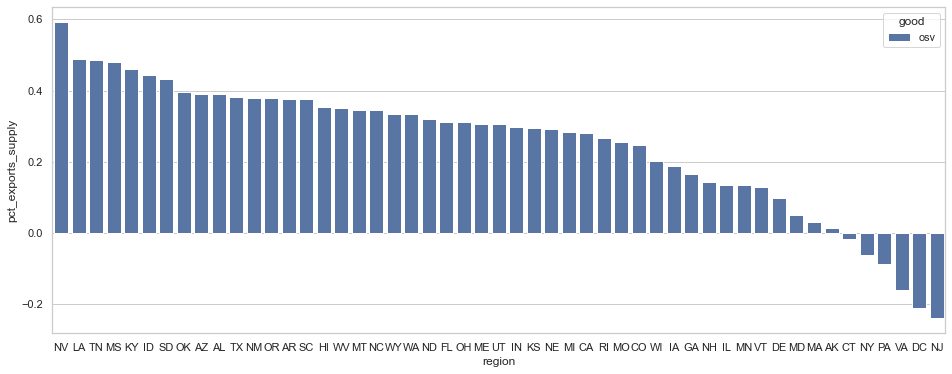

In [13]:
cons_b_gr=cd0_h_d_rpt.groupby(['region','good'],as_index=False).sum()
ys0_gr=ys0_rpt.groupby(['region','good'],as_index=False).sum()
benchmark_exports=cons_b_gr.merge(ys0_gr,on=['region','good'])
benchmark_exports['exports']=benchmark_exports['benchmark_supply']-benchmark_exports['benchmark_disagg_cons']
benchmark_exports['pct_exports_supply']=benchmark_exports['exports']/benchmark_exports['benchmark_supply']

for i in ['hou','amb','fbp','hos','res','osv']:
    fig, ax = plt.subplots(1, 1,figsize=(16,6))

    
    benchmark_exports_lm=benchmark_exports[benchmark_exports['good']==i].sort_values(by='pct_exports_supply',ascending=False)
    
    sns.set_theme(style="whitegrid")
    g = sns.barplot(
        data=benchmark_exports_lm,
        x="region", y='pct_exports_supply',hue='good')


In [17]:
labor_breakout=le0_d_rpt.groupby(['region','skill'],as_index=False).sum()

labor_breakout_tot=le0_d_rpt.groupby(['region'],as_index=False).sum()
labor_breakout_tot=labor_breakout_tot.rename(columns={"benchmark_le0":"benchmark_le0_tot"})
labor_breakout=labor_breakout.merge(labor_breakout_tot,on='region')
labor_breakout['pct_total']=labor_breakout['benchmark_le0']/labor_breakout['benchmark_le0_tot']

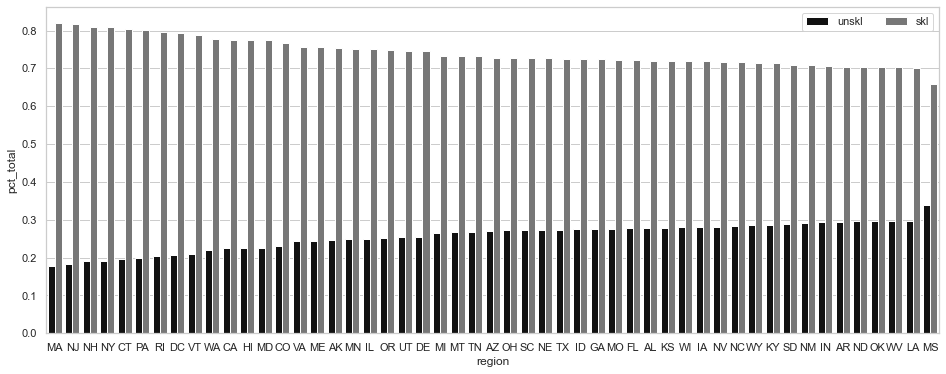

In [18]:
fig, ax = plt.subplots(1, 1,figsize=(16,6))
labor_breakout=labor_breakout.sort_values(by=['pct_total'],ascending=True)

sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=labor_breakout,
    x="region", y='pct_total',hue='skill',
   palette=['#111111','#777777']
)
plt.legend(ncol=2)


In [30]:
####get expenditure share on medical care by state

cd0_breakout=cd0_h_d_rpt[cd0_h_d_rpt['good'].isin(['hou','amb','fbp','hos','res'])].groupby(['region','good'],as_index=False).sum()
cd0_breakout_tot=cd0_h_d_rpt.groupby(['region'],as_index=False).sum()
cd0_breakout_tot=cd0_breakout_tot.rename(columns={"benchmark_disagg_cons":"benchmark_disagg_cons_tot"})
cd0_breakout=cd0_breakout.merge(cd0_breakout_tot,on=['region'])
cd0_breakout['pct_total']=cd0_breakout['benchmark_disagg_cons']/cd0_breakout['benchmark_disagg_cons_tot']



In [31]:
cd0_breakout

,region,good,benchmark_disagg_cons,benchmark_disagg_cons_tot,pct_total
0,AK,amb,3.661654,33.232537,0.110183
1,AK,fbp,2.333200,33.232537,0.070208
2,AK,hos,3.844281,33.232537,0.115678
3,AK,hou,5.488922,33.232537,0.165167
4,AK,res,2.240794,33.232537,0.067428
...,...,...,...,...,...
250,WY,amb,1.753837,21.536735,0.081435
251,WY,fbp,1.553307,21.536735,0.072124
252,WY,hos,1.841311,21.536735,0.085496
253,WY,hou,3.614890,21.536735,0.167848


Text(0, 0.5, 'Percent of Total Consumer Expenditure Bundle')

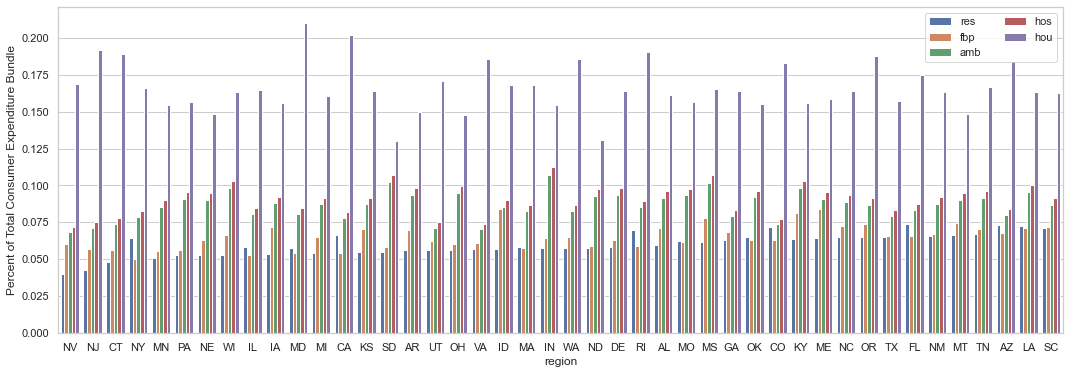

In [35]:
fig, ax = plt.subplots(1, 1,figsize=(18,6))
cd0_breakout=cd0_breakout.sort_values(by=['pct_total'],ascending=True)
cd0_breakout=cd0_breakout[~cd0_breakout.isin(['AK','DC','HI','NH','VT','WY','WV'])]
sns.set_theme(style="whitegrid")

g = sns.barplot(
    data=cd0_breakout,
    x="region", y='pct_total',hue='good'
)
plt.legend(ncol=2)
plt.ylabel('Percent of Total Consumer Expenditure Bundle')

In [20]:
ys0_rpt_gr=ys0_rpt.groupby(['region','good'],as_index=False).sum()
cd0_gr=cd0_h_d_rpt.groupby(['region','good'],as_index=False).sum()